## Build Book Recommender System-sklearn

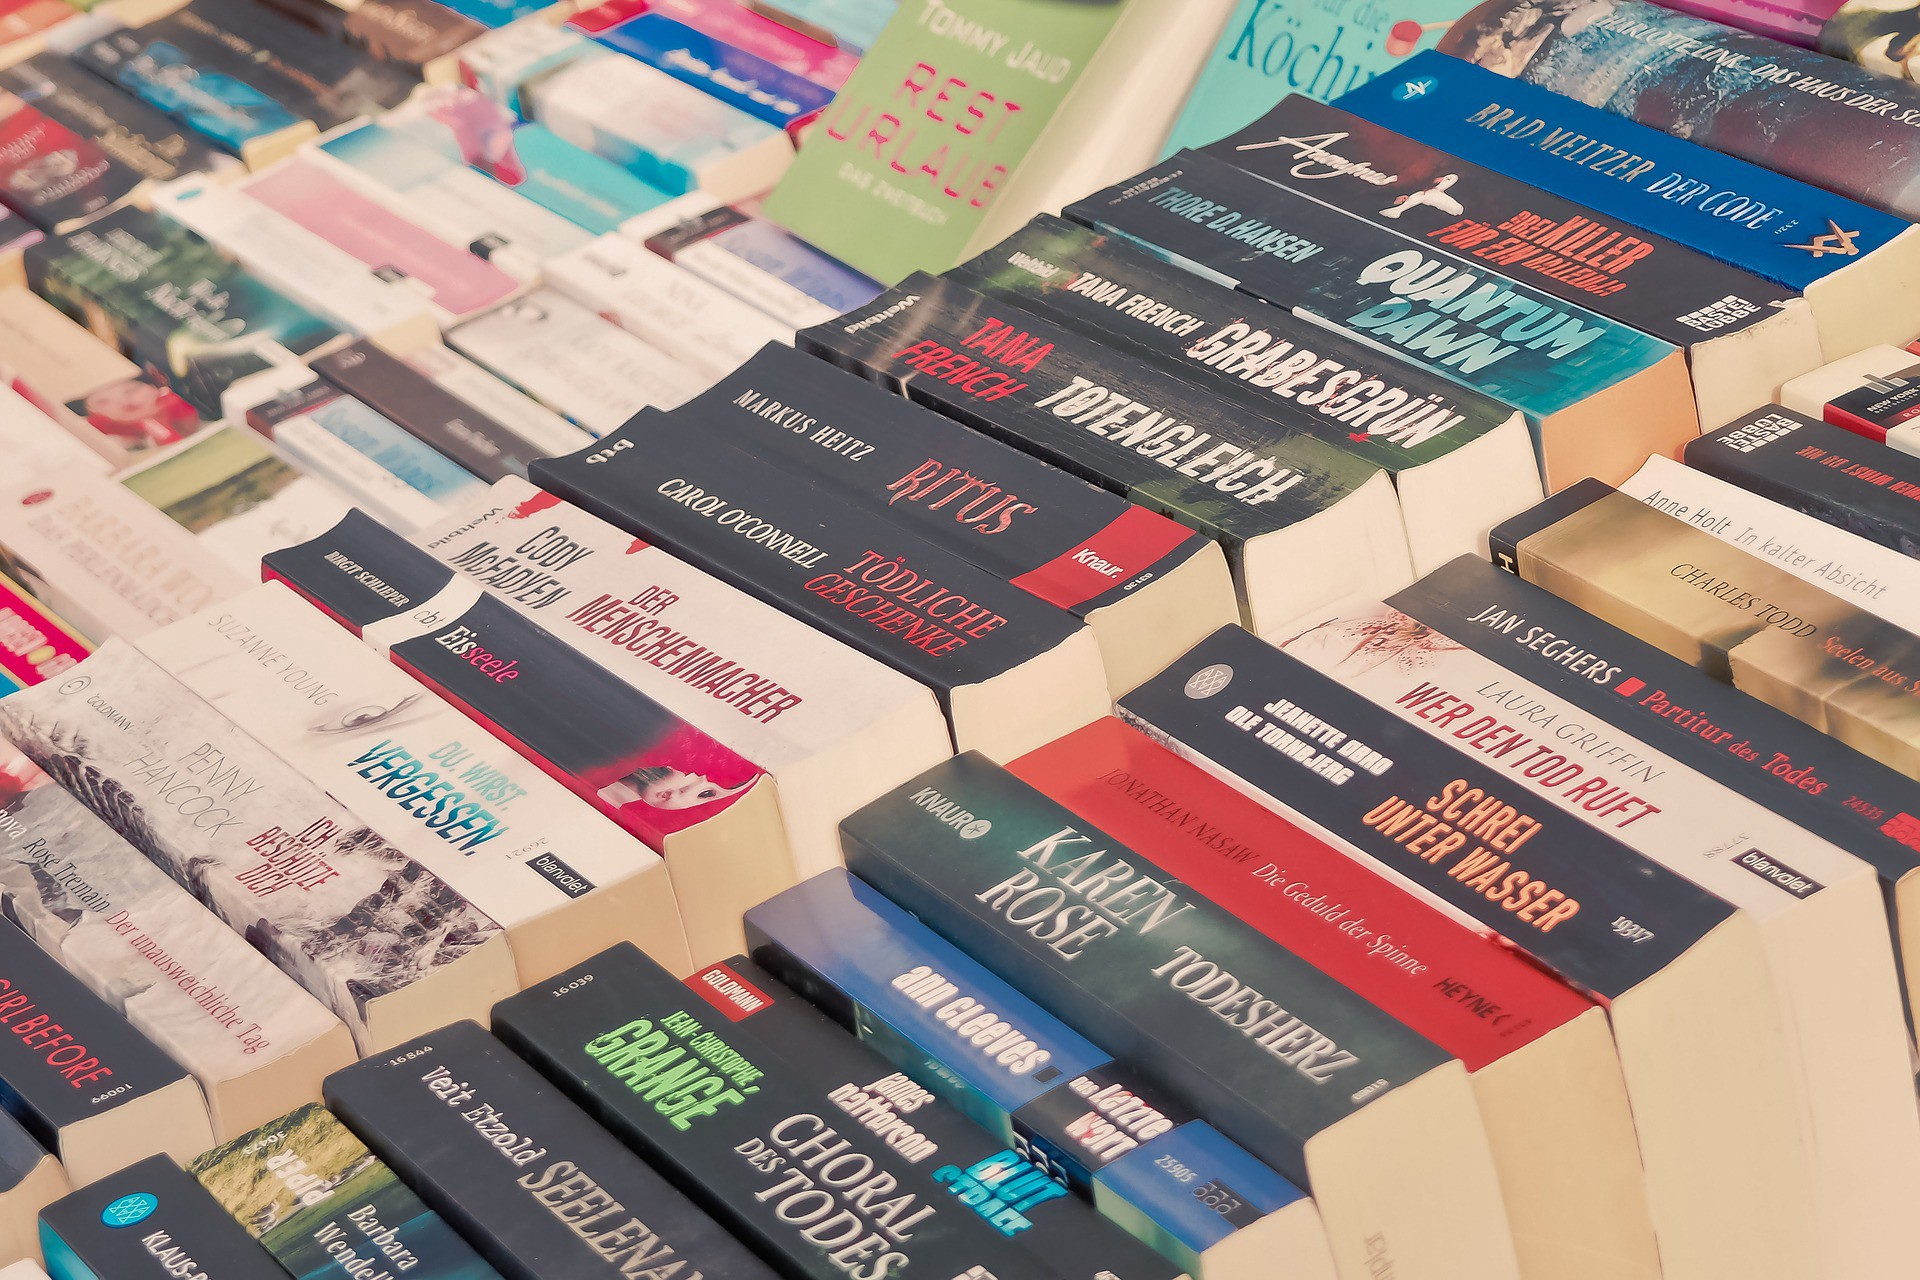

In [2]:
from IPython.display import Image
Image(filename='1_Gql-Vlc4BQJz_x8GhJXX2A.jpeg') 

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import sklearn
from sklearn.decomposition import TruncatedSVD

In [ ]:
book = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
book.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

In [ ]:
user = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
user.columns = ['userID', 'Location', 'Age']

In [ ]:
rating = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']

In [2]:
rating.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [3]:
user.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
book.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
combine_book_rating = pd.merge(rating, book, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


### popular books

Remove rows where book title is missing

In [6]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['bookTitle'])

In [7]:
book_ratingCount = (combine_book_rating.
     groupby(by = ['bookTitle'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalRatingCount'})
     [['bookTitle', 'totalRatingCount']]
    )
book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [8]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,276725,034545104X,0,Flesh Tones: A Novel,60
1,2313,034545104X,5,Flesh Tones: A Novel,60
2,6543,034545104X,0,Flesh Tones: A Novel,60
3,8680,034545104X,5,Flesh Tones: A Novel,60
4,10314,034545104X,9,Flesh Tones: A Novel,60


In [9]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

count   241071.000
mean         4.277
std         16.739
min          1.000
25%          1.000
50%          1.000
75%          3.000
max       2502.000
Name: totalRatingCount, dtype: float64


In [10]:
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    7.000
0.910    8.000
0.920    9.000
0.930   10.000
0.940   11.000
0.950   13.000
0.960   16.000
0.970   20.000
0.980   29.000
0.990   50.000
Name: totalRatingCount, dtype: float64


In [11]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,276725,034545104X,0,Flesh Tones: A Novel,60
1,2313,034545104X,5,Flesh Tones: A Novel,60
2,6543,034545104X,0,Flesh Tones: A Novel,60
3,8680,034545104X,5,Flesh Tones: A Novel,60
4,10314,034545104X,9,Flesh Tones: A Novel,60


#### Filtering to US users only

In [12]:
combined = rating_popular_book.merge(user, left_on = 'userID', right_on = 'userID', how = 'left')

us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_canada_user_rating=us_canada_user_rating.drop('Age', axis=1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,276725,034545104X,0,Flesh Tones: A Novel,60,"tyler, texas, usa"
1,2313,034545104X,5,Flesh Tones: A Novel,60,"cincinnati, ohio, usa"
2,6543,034545104X,0,Flesh Tones: A Novel,60,"strafford, missouri, usa"
3,8680,034545104X,5,Flesh Tones: A Novel,60,"st. charles county, missouri, usa"
4,10314,034545104X,9,Flesh Tones: A Novel,60,"beaverton, oregon, usa"


In [13]:
if not us_canada_user_rating[us_canada_user_rating.duplicated(['userID', 'bookTitle'])].empty:
    initial_rows = us_canada_user_rating.shape[0]

    print('Initial dataframe shape {0}'.format(us_canada_user_rating.shape))
    us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
    current_rows = us_canada_user_rating.shape[0]
    print('New dataframe shape {0}'.format(us_canada_user_rating.shape))
    print('Removed {0} rows'.format(initial_rows - current_rows))

Initial dataframe shape (251615, 6)
New dataframe shape (248949, 6)
Removed 2666 rows


In [14]:
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

In [15]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [16]:
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index, :].reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for The Stone Diaries:

1: Daisy Fay and the Miracle Man, with distance of 0.8766136287164453:
2: Atonement : A Novel, with distance of 0.9037760905570096:
3: Cat's Eye, with distance of 0.9055037726842934:
4: Blue Shoe, with distance of 0.9074036088730074:
5: Waiting, with distance of 0.9096390816180597:


C:\Users\Susan\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


In [17]:
us_canada_user_rating_pivot2 = us_canada_user_rating.pivot(index = 'userID', columns = 'bookTitle', values = 'bookRating').fillna(0)

In [18]:
us_canada_user_rating_pivot2.head()

bookTitle,10 Lb. Penalty,16 Lighthouse Road,1984,1st to Die: A Novel,2010: Odyssey Two,204 Rosewood Lane,2061: Odyssey Three,24 Hours,2nd Chance,3rd Degree,...,YOU BELONG TO ME,Year of Wonders,You Belong To Me,You Shall Know Our Velocity,Young Wives,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zoya,"\O\"" Is for Outlaw""","\Surely You're Joking, Mr. Feynman!\"": Adventures of a Curious Character""",stardust
userID,,,,,,,,,,,,,,,,,,,,,
8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
14,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
16,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
17,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [19]:
us_canada_user_rating_pivot2.shape

(40017, 2442)

In [20]:
X = us_canada_user_rating_pivot2.values.T
X.shape

(2442, 40017)

In [21]:
import sklearn
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=12, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

(2442, 12)

In [23]:
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
corr = np.corrcoef(matrix)
corr.shape

(2442, 2442)

In [24]:
us_canada_book_title = us_canada_user_rating_pivot2.columns
us_canada_book_list = list(us_canada_book_title)
coffey_hands = us_canada_book_list.index("The Green Mile: Coffey's Hands (Green Mile Series)")
print(coffey_hands)

1906


In [25]:
corr_coffey_hands  = corr[coffey_hands]

In [26]:
list(us_canada_book_title[(corr_coffey_hands<1.0) & (corr_coffey_hands>0.9)])

['Needful Things',
 'The Bachman Books: Rage, the Long Walk, Roadwork, the Running Man',
 'The Green Mile: Coffey on the Mile (Green Mile Series)',
 'The Green Mile: Night Journey (Green Mile Series)',
 'The Green Mile: The Bad Death of Eduard Delacroix (Green Mile Series)',
 'The Green Mile: The Mouse on the Mile (Green Mile Series)',
 'The Shining',
 'The Two Dead Girls (Green Mile Series)']